Esse *notebook* é a primeira tentative de recontruir os dados com as regiões de erro já identificadas,

In [1]:
import sys
sys.path.insert(1, '../../Pipeline')

import imp
import utils
imp.reload(utils)
from utils import *

In [2]:
# Python imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Pandas Config
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Notebook Theme
# try:
#     from jupyterthemes import jtplot
#     jtplot.style()
# except:
#     pass

# ML imports
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import xgboost

ip = pd.read_csv('../../../data/cleandata/Info pluviometricas/Merged Data/merged_wRegions.csv',
                 sep = ';',
                 dtype = {'Local_0': object, 'Local_1':object,
                          'Local_2':object,  'Local_3':object})

print(ip.columns)
ip.head()

Index(['index', 'Data', 'Hora', 'Data / Hora', 'UmidadeRelativa_0',
       'PressaoAtmosferica_0', 'Temperatura do Ar_0', 'TemperaturaInterna_0',
       'PontoDeOrvalho_0', 'SensacaoTermica_0',
       ...
       'VelocidadeDoVento_0_error', 'VelocidadeDoVento_1_error',
       'VelocidadeDoVento_2_error', 'VelocidadeDoVento_3_error',
       'VelocidadeDoVento_4_error', 'Precipitacao_0_error',
       'Precipitacao_1_error', 'Precipitacao_2_error', 'Precipitacao_3_error',
       'Precipitacao_4_error'],
      dtype='object', length=109)


,index,Data,Hora,Data / Hora,UmidadeRelativa_0,PressaoAtmosferica_0,Temperatura do Ar_0,TemperaturaInterna_0,PontoDeOrvalho_0,SensacaoTermica_0,RadiacaoSolar_0,DirecaoDoVento_0,VelocidadeDoVento_0,Precipitacao_0,Local_0,UmidadeRelativa_1,PressaoAtmosferica_1,Temperatura do Ar_1,TemperaturaInterna_1,PontoDeOrvalho_1,SensacaoTermica_1,RadiacaoSolar_1,DirecaoDoVento_1,VelocidadeDoVento_1,Precipitacao_1,Local_1,UmidadeRelativa_2,PressaoAtmosferica_2,Temperatura do Ar_2,TemperaturaInterna_2,PontoDeOrvalho_2,SensacaoTermica_2,RadiacaoSolar_2,DirecaoDoVento_2,VelocidadeDoVento_2,Precipitacao_2,Local_2,UmidadeRelativa_3,PressaoAtmosferica_3,Temperatura do Ar_3,TemperaturaInterna_3,PontoDeOrvalho_3,SensacaoTermica_3,RadiacaoSolar_3,DirecaoDoVento_3,VelocidadeDoVento_3,Precipitacao_3,Local_3,UmidadeRelativa_4,PressaoAtmosferica_4,Temperatura do Ar_4,TemperaturaInterna_4,PontoDeOrvalho_4,SensacaoTermica_4,RadiacaoSolar_4,DirecaoDoVento_4,VelocidadeDoVento_4,Precipitacao_4,Local_4,UmidadeRelativa_0_error,UmidadeRelativa_1_error,UmidadeRelativa_2_error,UmidadeRelativa_3_error,UmidadeRelativa_4_error,PressaoAtmosferica_0_error,PressaoAtmosferica_1_error,PressaoAtmosferica_2_error,PressaoAtmosferica_3_error,PressaoAtmosferica_4_error,Temperatura do Ar_0_error,Temperatura do Ar_1_error,Temperatura do Ar_2_error,Temperatura do Ar_3_error,Temperatura do Ar_4_error,TemperaturaInterna_0_error,TemperaturaInterna_1_error,TemperaturaInterna_2_error,TemperaturaInterna_3_error,TemperaturaInterna_4_error,PontoDeOrvalho_0_error,PontoDeOrvalho_1_error,PontoDeOrvalho_2_error,PontoDeOrvalho_3_error,PontoDeOrvalho_4_error,SensacaoTermica_0_error,SensacaoTermica_1_error,SensacaoTermica_2_error,SensacaoTermica_3_error,SensacaoTermica_4_error,RadiacaoSolar_0_error,RadiacaoSolar_1_error,RadiacaoSolar_2_error,RadiacaoSolar_3_error,RadiacaoSolar_4_error,DirecaoDoVento_0_error,DirecaoDoVento_1_error,DirecaoDoVento_2_error,DirecaoDoVento_3_error,DirecaoDoVento_4_error,VelocidadeDoVento_0_error,VelocidadeDoVento_1_error,VelocidadeDoVento_2_error,VelocidadeDoVento_3_error,VelocidadeDoVento_4_error,Precipitacao_0_error,Precipitacao_1_error,Precipitacao_2_error,Precipitacao_3_error,Precipitacao_4_error
0,147680,01/01/11,00:00:59,2011-01-01 00:00:59,92.3,919.1,19.3,22.7,18.0,NaN,0.0,101.0,2.6,0.0,Paraiso,88.8,920.5,19.6,22.9,17.7,NaN,0.0,133.0,0.7,0.0,Erasmo,84.8,920.6,20.2,22.8,17.5,NaN,0.0,137.0,1.5,0.0,Camilopolis,86.6,926.7,20.1,23.3,17.8,NaN,0.0,131.0,2.5,0.0,RM,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,Vitoria,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,False,True,True,True,True,True,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False
1,147679,01/01/11,00:16:59,2011-01-01 00:16:59,90.4,918.9,19.3,22.6,17.7,NaN,0.0,115.0,3.4,0.2,Paraiso,87.2,920.3,19.6,22.8,17.4,NaN,0.0,96.0,3.6,0.0,Erasmo,84.1,920.3,20.1,22.8,17.4,NaN,0.0,76.0,1.9,0.0,Camilopolis,85.9,926.4,20.2,23.4,17.7,NaN,0.0,154.0,2.7,0.0,RM,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,Vitoria,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,False,True,True,True,True,True,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False
2,147678,01/01/11,00:30:58,2011-01-01 00:30:58,90.6,918.8,19.2,22.6,17.6,NaN,0.0,103.0,1.1,0.2,Paraiso,87.3,920.2,19.6,22.8,17.5,NaN,0.0,124.0,2.4,0.0,Erasmo,83.9,920.2,20.1,22.9,17.2,NaN,0.0,92.0,2.9,0.0,Camilopolis,85.8,926.4,20.1,23.4,17.7,NaN,0.0,129.0,1.8,0.0,RM,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,Vitoria,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,False,True,True,True,True,True,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,F

## Validate Regions

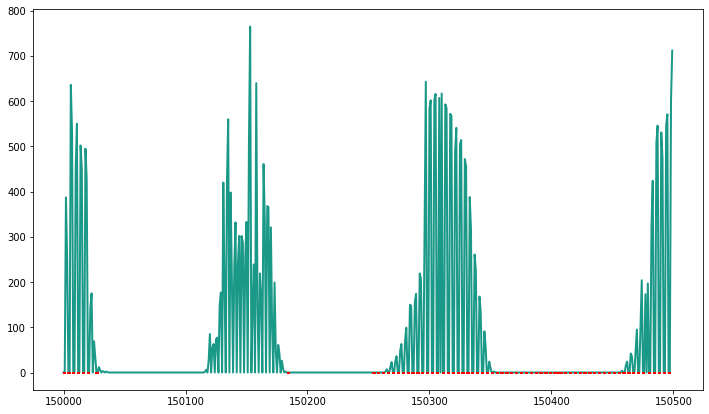

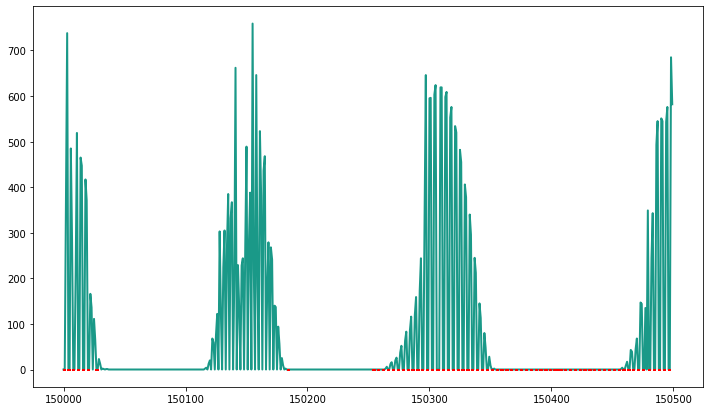

In [3]:
select = 'RadiacaoSolar_4'
start, stop = 150000, 150500

## ===================================
error = ip[select + '_error'].to_list()
error_reg = list_2_regions(error)
plot_regions(ip[select].fillna(0), error_reg, start, stop, plt_type = 'lines')

select = 'RadiacaoSolar_2'

## ===================================
error = ip[select + '_error'].to_list()
error_reg = list_2_regions(error)
plot_regions(ip[select].fillna(0), error_reg, start, stop, plt_type = 'lines')

In [4]:
ip[['Date', 'Time']] = ip['Data / Hora'].str.split(expand=True)
ip[['Hora','Min','Seg']] = ip['Time'].str.split(':', expand = True)
ip['Hora'] = ip['Hora'].astype(int)

## Interpolation

In [5]:
cols_rad = [i for i in ip.columns if 'RadiacaoSolar' in i]
rad = ip[['Hora'] + cols_rad].copy(deep = True)
rad.head()

,Hora,RadiacaoSolar_0,RadiacaoSolar_1,RadiacaoSolar_2,RadiacaoSolar_3,RadiacaoSolar_4,RadiacaoSolar_0_error,RadiacaoSolar_1_error,RadiacaoSolar_2_error,RadiacaoSolar_3_error,RadiacaoSolar_4_error
0,0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True
1,0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True
2,0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True
3,0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True
4,1,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True


In [6]:
print(ip['RadiacaoSolar_0_error'].sum())
print(ip['RadiacaoSolar_1_error'].sum())
print(ip['RadiacaoSolar_2_error'].sum())
print(ip['RadiacaoSolar_3_error'].sum())
print(ip['RadiacaoSolar_4_error'].sum())

100035
300359
103220
103630
194661


In [7]:
error = rad['RadiacaoSolar_0_error']
error_reg = list_2_regions(error)

In [8]:
reg_size = [i[1] - i[0] for i in error_reg]
max_size = 5

interpol_reg = [error_reg[i] for i in range(len(reg_size)) if reg_size[i] <= max_size]
rad['RadiacaoSolar_0_interpol']  = regions_2_list(interpol_reg, len(rad))
rad.loc[rad['RadiacaoSolar_0_interpol'],'RadiacaoSolar_0_error'] = False
#rad['RadiacaoSolar_0_error'] = rad['RadiacaoSolar_0_error'] & ~rad['RadiacaoSolar_0_interpol']

In [9]:
s = rad['RadiacaoSolar_0']
s = s.fillna(-1)
s[rad['RadiacaoSolar_0_interpol']] = np.nan
s = s.interpolate(method = 'linear', limit = max_size)
s[s == -1] = np.nan
rad['RadiacaoSolar_0'] = s

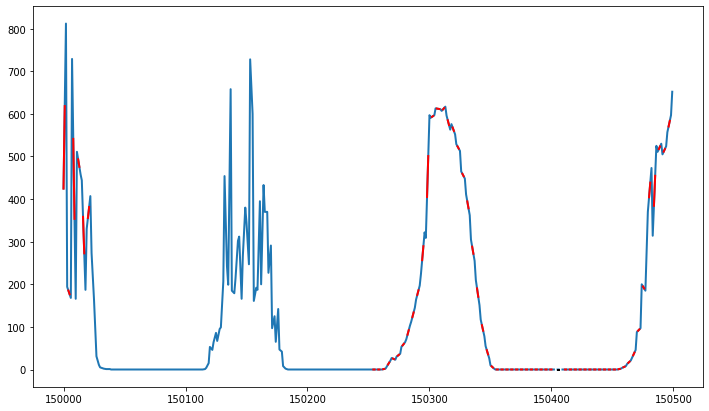

In [10]:
start, stop = 150000, 150500
plt.figure(figsize = (12,7))
plt.plot(s[start:stop], lw = 2)
plt.plot(s[start:stop].where(rad['RadiacaoSolar_0_interpol'][start:stop]), c = 'red', lw =2)
plt.plot(s[start:stop].where(rad['RadiacaoSolar_0_error'][start:stop]), c = 'black', lw = 2)
plt.show()

## Regressor RadiacaoSolar_0

In [11]:
label = 'RadiacaoSolar_0'
features = rad.drop(columns=label).columns.to_list()

## History pivot - *shift*

- https://support.ptc.com/help/thingworx_hc/thingworx_analytics_8/index.html#page/thingworx_analytics_8/twxa-time-series.html

> Time series data also differs somewhat from non-time series data in the training of predictive models. A lookbackSize parameter is required for training time series models. The **lookbackSize** defines the number of recent data points to be used when predicting each future value in the time series. Any value greater than 1 is acceptable but generally, a power of 2 is used (2, 4, 8, 16). Larger values affect performance because more records are used for predictions. When a value of 0 is specified, auto-windowing will take place and ThingWorx Analytics will try a set of lookback sizes (2, 4, 8, and 16) in order to select the size that produces the most accurate results.
>
> Training a time series predictive model also requires a **lookahead** parameter that indicates the number of time steps ahead to predict. In most cases, the lookahead defaults to 1 (it defaults to 0 if goal history is not in use). A lookahead of 1 means the model can be used to predict one time step ahead. To predict outcomes further ahead, enter any value greater than 1.
>
> Because basic machine learning algorithms are not time-aware, ThingWorx Analytics uses **history pivoting** to transform time series data into non-time series data that can be trained using the same basic algorithms as non-time series data. During this transformation, the data is grouped and sorted, by entity and time, and any necessary interpolations take place to produce Analytics-ready data. The table below shows the history-pivoted data from both sets of time series predictions shown above.

> Aplication Example:
>
> Creating a Virtual Sensor – A very expensive sensor is added to a pump to measure its efficiency in a controlled environment. The sensor captures running conditions on the pump and captures readings for the pump's efficiency. That pump also has several inexpensive sensors that are also collecting data. A model can be trained to emulate this expensive sensor, as a virtual sensor, by predicting its value from the inexpensive sensor values. From there, many pumps could be deployed with only the inexpensive sensors. By using the model created on the first pump, each pump could have a virtual version of the expensive sensor without the cost of it being deployed with each pump

Shift do Label (RadiacaoSolar_0) e também do erro do label.

O shift do erro do label permite eliminar as amostras com o valor atrasado errado após o shift. A eliminação dos erros a posteriori garante que a amostra apenas terá dados contínuos.

Para o treinamento é importante utilizar apenas dados considerados corretos. Isso é necessário não somente para o _Label_ mas também para os _Features_ de treinamento - dados das outras estações da amostra atual e os dados atrasados do label. 

> Shift = atrasar valores por uma amostra

In [12]:
horas = 24
print('Amostras necessárias:', horas*60/ 15)

Amostras necessárias: 96.0


In [13]:
rad_d = rad.copy(deep = True)
lookbackSize = 30

for i in range(1,lookbackSize + 1):
    rad_d['delay_' + str(i)] = rad['RadiacaoSolar_0'].shift(i)
for i in range(1,lookbackSize + 1):
    rad_d['delay_error_' + str(i)] = rad['RadiacaoSolar_0_error'].shift(i)
    
cols_delay = [i for i in rad_d.columns if 'delay' in i]
print('Dataframe completo: ', len(rad_d), 'amostras')
rad_d.head(5)

Dataframe completo:  393178 amostras


,Hora,RadiacaoSolar_0,RadiacaoSolar_1,RadiacaoSolar_2,RadiacaoSolar_3,RadiacaoSolar_4,RadiacaoSolar_0_error,RadiacaoSolar_1_error,RadiacaoSolar_2_error,RadiacaoSolar_3_error,RadiacaoSolar_4_error,RadiacaoSolar_0_interpol,delay_1,delay_2,delay_3,delay_4,delay_5,delay_6,delay_7,delay_8,delay_9,delay_10,delay_11,delay_12,delay_13,delay_14,delay_15,delay_16,delay_17,delay_18,delay_19,delay_20,delay_21,delay_22,delay_23,delay_24,delay_25,delay_26,delay_27,delay_28,delay_29,delay_30,delay_error_1,delay_error_2,delay_error_3,delay_error_4,delay_error_5,delay_error_6,delay_error_7,delay_error_8,delay_error_9,delay_error_10,delay_error_11,delay_error_12,delay_error_13,delay_error_14,delay_error_15,delay_error_16,delay_error_17,delay_error_18,delay_error_19,delay_error_20,delay_error_21,delay_error_22,delay_error_23,delay_error_24,delay_error_25,delay_error_26,delay_error_27,delay_error_28,delay_error_29,delay_error_30
0,0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Eliminar dados errados

In [14]:
error_cols_all_features = [i for i in rad_d.columns if 'error' in i ]
i = 0 
for col in error_cols_all_features:
    if i == 0:
        has_error_all_features = rad_d[col]
        i+=1
    else:
        has_error_all_features = has_error_all_features | rad_d[col].fillna(value = True)
        
rad_e_all_features = rad_d[has_error_all_features == False].drop(columns = error_cols_all_features)

print('Dados com erro: ', has_error_all_features.sum()/len(rad_d)*100, '%')
print('Dados com erro :', has_error_all_features.sum(), 'amostras')
print('Dados corretos:', len(rad_e_all_features), 'amostras')

Dados com erro:  85.067323197127 %
Dados com erro : 334466 amostras
Dados corretos: 58712 amostras


Os dados com erro representam 89.9% de todo o dataset, isso é, considerando o erro das outras estações e o erro do label (**RadiacaoSolar_0**) para as colunas de atraso (*delay*).

In [15]:
error_cols = [i for i in rad_d.columns if 'delay_error' in i or i == 'RadiacaoSolar_0_error']
i = 0 
for col in error_cols:
    if i == 0:
        has_error = rad_d[col]
        i+=1
    else:
        has_error = has_error | rad_d[col].fillna(value = True)
        
rad_e = rad_d[has_error == False].drop(columns = error_cols)

print('Dados com erro: ', has_error.sum()/len(rad_d)*100, '%')
print('Dados com erro :', has_error.sum(), 'amostras')
print('Dados corretos:', len(rad_e), 'amostras')

Dados com erro:  8.015707898203866 %
Dados com erro : 31516 amostras
Dados corretos: 361662 amostras


Quando não consideramos os dados das outras estações com erro, os dados errados caiem de 89,9% para 22.9%. Portanto a seguir utilizaremos a segunda opção e para lidar com os dados errados das outras estações será incluido no treinamento os features de erro *'RadiacaoSolar_x_error'* .

In [16]:
# Achar Continuidade

rad_0 = rad_e[label].dropna()
regions, sizes = [],[]
init = rad_0.index[0]
for i in range(1,len(rad_0.index ) -1):
    if rad_0.index[i] + 1 != rad_0.index[i+1] :
        final = rad_0.index[i]
        regions.append([init, final])
        sizes.append(final-init)
        init = rad_0.index[i + 1]
print(len(regions))

352


In [17]:
rad_e.columns
plot_cols = [i for i in rad_e.columns if 'delay' not in i and 'error' not in i]
print(plot_cols)

['Hora', 'RadiacaoSolar_0', 'RadiacaoSolar_1', 'RadiacaoSolar_2', 'RadiacaoSolar_3', 'RadiacaoSolar_4', 'RadiacaoSolar_0_interpol']


In [18]:
# figsize = (12,7 * len(plot_cols))
# fig, ax = plt.subplots(len(plot_cols), 1,figsize = figsize)
# i = 0
# for col in ['RadiacaoSolar_0']:
#     for reg in regions:
#         start, stop = reg
#         ax[i].plot(rad_e[[col]].loc[start:stop].index, rad_e[[col]].loc[start:stop])
#         ax[i].set_title(col)
#     i+=1
# plt.show()

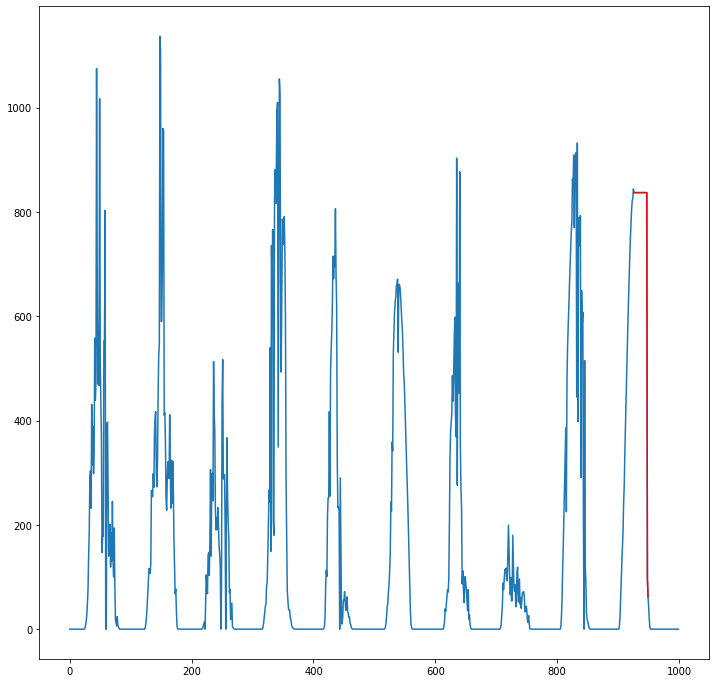

In [19]:
start, stop = 0, 1000

plt.figure(figsize= (12,12))
plt.plot(rad['RadiacaoSolar_0'][start:stop].fillna(0))
plt.plot(rad['RadiacaoSolar_0'][start:stop].where(rad['RadiacaoSolar_0_error'][start:stop]),
          c = 'red')
plt.show()

## TimeSeries Split - Cross Validation

Documentation:
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

Example
- https://medium.com/keita-starts-data-science/time-series-split-with-scikit-learn-74f5be38489e

Why use K-1 Cross Validation instead of K_FOLD CV?

>Time-series (or other intrinsically ordered data) can be problematic for cross-validation. If some pattern emerges in year 3 and stays for years 4-6, then your model can pick up on it, even though it wasn't part of years 1 & 2.
>An approach that's sometimes more principled for time series is forward chaining, where your procedure would be something like this:
>fold 1 : training [1], test [2]
>fold 2 : training [1 2], test [3]
>fold 3 : training [1 2 3], test [4]
>fold 4 : training [1 2 3 4], test [5]
>fold 5 : training [1 2 3 4 5], test [6]
>That more accurately models the situation you'll see at prediction time, where you'll model on past data and predict on forward-looking data. It also will give you a sense of the dependence of your modeling on data size.

- https://stackoverflow.com/questions/26991997/multiple-line-quote-in-markdown?rq=1

Why every statistician should know about cross-validation
- https://robjhyndman.com/hyndsight/crossvalidation/

> Cross-validation is primarily a way of measuring the predictive performance of a statistical model. Every statistician knows that the model fit statistics are not a good guide to how well a model will predict: high 
$R^2$ does not necessarily mean a good model. It is easy to over-fit the data by including too many degrees of freedom and so inflate $R^2$ and other fit statistics.

> Minimizing a CV statistic is a useful way to do model selection such as choosing variables in a regression or choosing the degrees of freedom of a nonparametric smoother. It is certainly far better than procedures based on statistical tests and provides a nearly unbiased measure of the true MSE on new observations.

> **Cross-validation for time series**
>
>When the data are not independent cross-validation becomes more difficult as leaving out an observation does not remove all the associated information due to the correlations with other observations. For time series forecasting, a cross-validation statistic is obtained as follows
>
>    1. Fit the model to the data $y_1, ..., y_t$ and let $ŷ_{t+1}$ denote the forecast of the next observation. Then compute the error $e^*_{t+1} = y_{t+1} - ŷ_{t+1}$ for the forecast observation.
>
>    2. Repeat step 1 for $t = m,...,n-1$ where $m$ is the minimum number of observations needed for fitting the model.
>
>    3. Compute the MSE from $e^*_{m+1}, ..., e^*_n$.

###### *Os dados estão organizados de forma que uma amostra k não depende de outra amostra k+n; k-1 CV é realmente necessário?*

Outros links:
- https://www.kaggle.com/c/ieee-fraud-detection/discussion/103065
- https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme

In [20]:
n_splits = 3

features = list(rad_e.drop(columns=[label]).columns)

label_i = rad_e.columns.get_loc(label)
features_i = [rad_e.columns.get_loc(c) for c in features if c in rad]

X_train, X_test = [], []
y_train, y_test = [], []

tscv = TimeSeriesSplit(n_splits = n_splits)

for train_index, test_index in tscv.split(rad_e[[label]].dropna()):
    y_train.append(rad_e[label].iloc[train_index].values)
    y_test.append(rad_e[label].iloc[test_index].values)
    
    X_train.append(rad_e[features].iloc[train_index])
    X_test.append(rad_e[features].iloc[test_index])


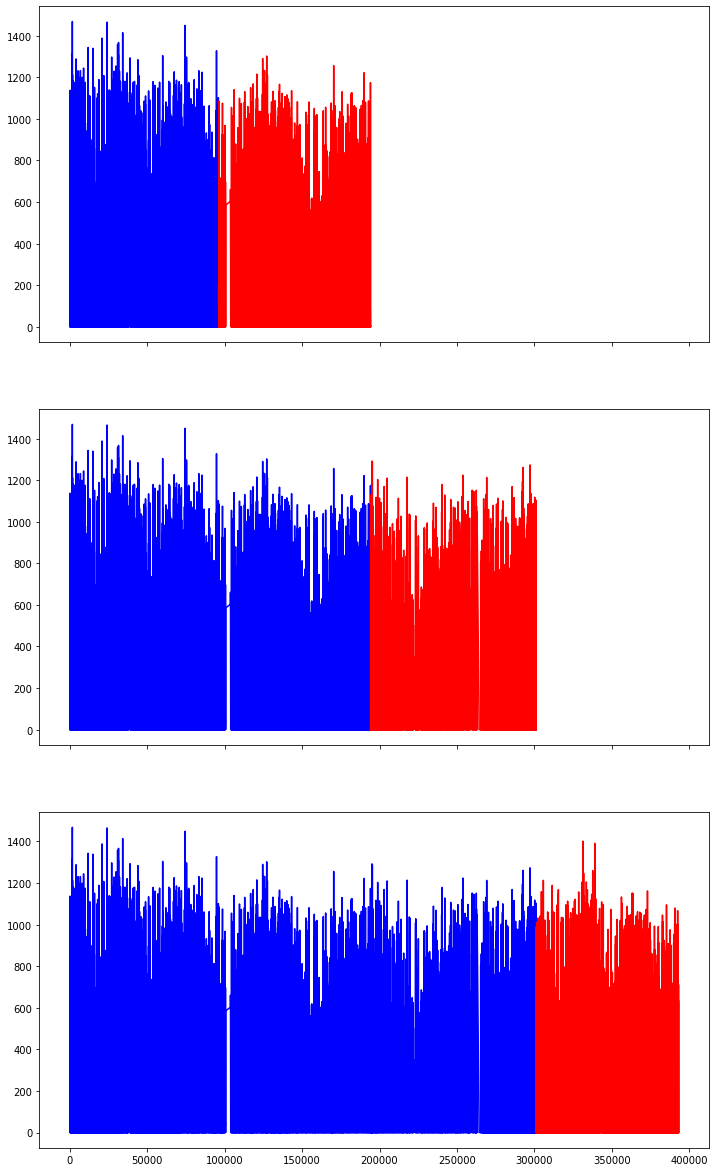

In [21]:
# Check CV regions
fig, ax = plt.subplots(n_splits, 1, figsize = (12,7*n_splits), sharex=True)
for n in range(n_splits):
    #ax[n].plot(rad_e[label], c='Green', alpha = 0.2)
    ax[n].plot(X_train[n].index, y_train[n], c='Blue')
    ax[n].plot(X_test[n].index,  y_test[n],c='Red') 

## Create model

In [22]:
xgb = []
y_predict = []

for n in range(n_splits):
    xgb.append(xgboost.XGBRegressor(objective='reg:squarederror'))
    xgb[n].fit(X_train[n], y_train[n])
    
    y_predict.append(xgb[n].predict(X_test[n]))

##  Score

In [ ]:
        # ================ #
        # Calculate Score  #
        # ================ #

## Predict tests samples

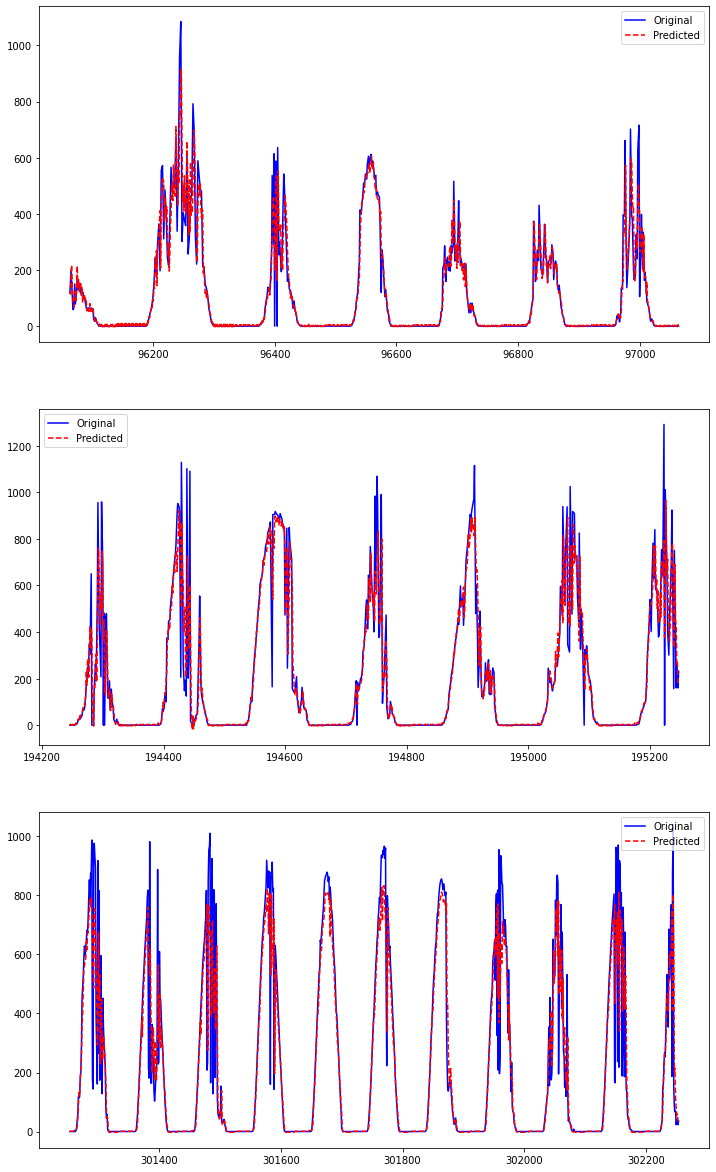

In [23]:
start, stop = 0, 1000

fig, ax = plt.subplots(n_splits, 1, figsize = (12,7*n_splits))

for n in range(n_splits):
    aux = X_test[n].index[0]
    len_ = stop - start
    x = np.linspace(aux,aux+len_ + 1,len_)
    d_start,d_stop = aux+start, aux+stop
    ax[n].plot(x, y_test[n][start:stop], c = 'blue', label = 'Original')
    ax[n].plot(x, y_predict[n][start:stop],'--', c = 'red', label = 'Predicted')
    ax[n].legend()    

plt.show()

## Predict on faulty data

In [24]:
drop_cols = [i for i in rad_d.columns if 'delay_error' in i]
drop_cols.append(label)
drop_cols.append(label+'_error')

In [25]:
val_predict = []
for n in range(n_splits):    
    val_predict.append(xgb[n].predict(rad_d.drop(columns = drop_cols)))

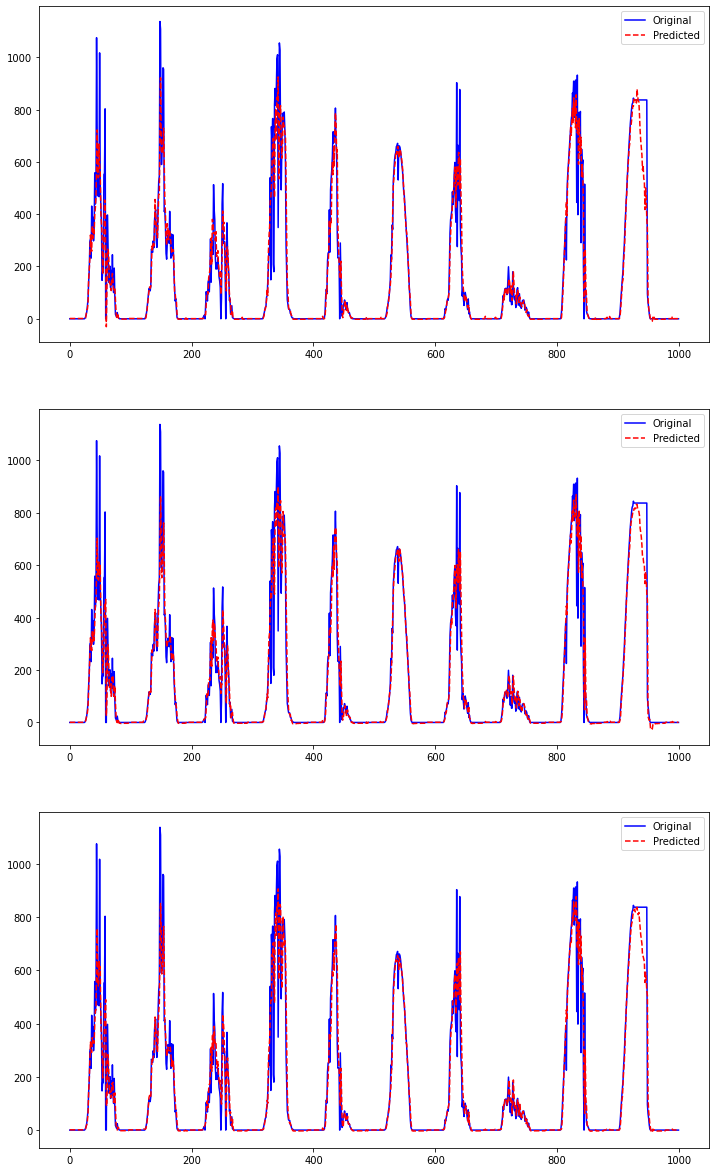

In [26]:
start, stop = 0, 1000

fig, ax = plt.subplots(n_splits, 1, figsize = (12,7*n_splits))

for n in range(n_splits):
    ax[n].plot(rad_d[start:stop].index, rad_d[label][start:stop], c = 'blue', label = 'Original')
    ax[n].plot(rad_d[start:stop].index, val_predict[n][start:stop],'--', c = 'red', label = 'Predicted')
    ax[n].legend()
plt.show()

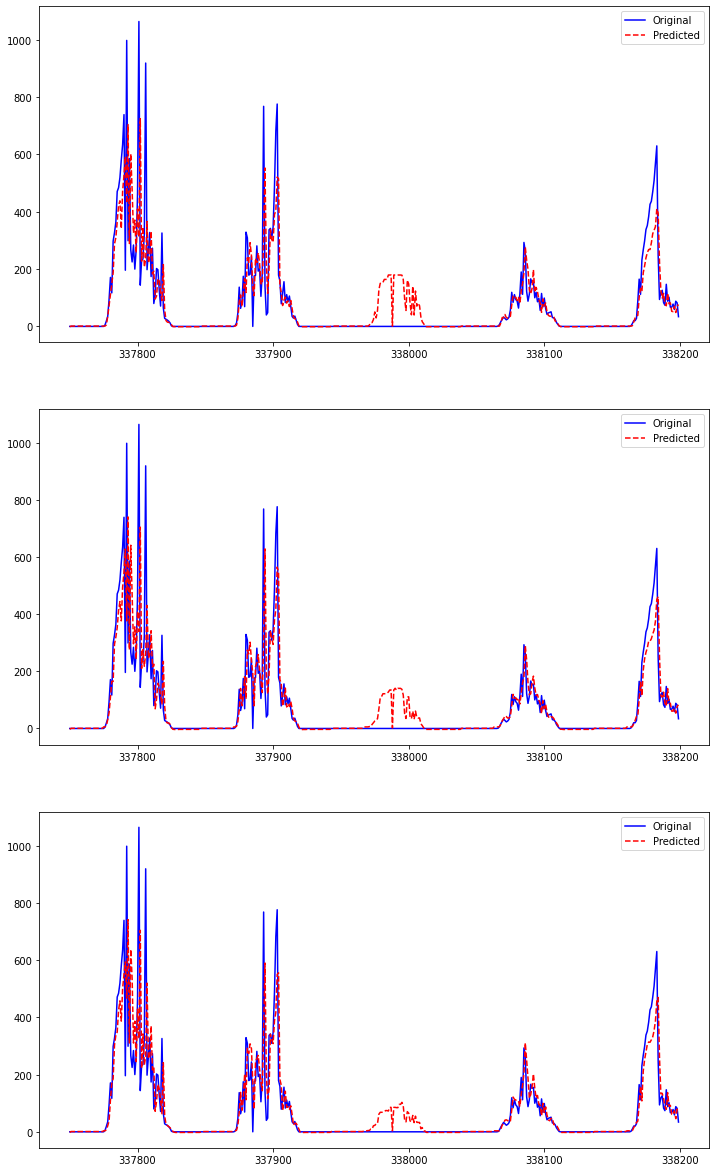

In [27]:
start, stop = 337750, 338200

fig, ax = plt.subplots(n_splits, 1, figsize = (12,7*n_splits))

for n in range(n_splits):
    ax[n].plot(rad_d[start:stop].index, rad_d[label][start:stop], c = 'blue', label = 'Original')
    ax[n].plot(rad_d[start:stop].index, val_predict[n][start:stop],'--', c = 'red', label = 'Predicted')
    ax[n].legend()
plt.show()

**Como que samples iguais (e.g. 345000 - 350000) produzem saídas diferentes?**

Essa previsão é feita *de uma vez só*. Proximo passo é testar com a previsão recorrente, isto é, prever amostra k, atualoziar os features de k+1, prever k+1.

## Recurrent prediction

In [28]:
recurrent_y = np.zeros(len(rad_d), dtype=np.float64)
rad_recurrent = rad_d.drop(columns = drop_cols).copy(deep = True)

start, stop = 337750, 338500
for i in range(start, stop, 1):
    x = rad_recurrent.loc[[i]]
    pred_ = xgb[2].predict(x)
    recurrent_y[i] = pred_
    for l in range(1, lookbackSize+1):
        rad_recurrent.loc[i + l, 'delay_' + str(l) ] = pred_

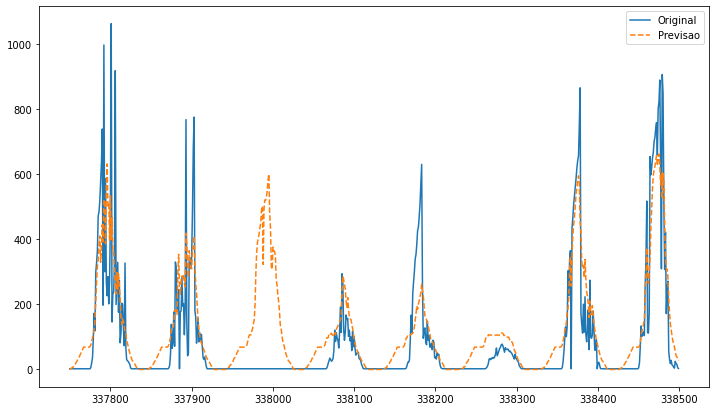

In [29]:
plt.figure(figsize = (12,7))
plt.plot(rad_d['RadiacaoSolar_0'][start:stop], label =  'Original')
plt.plot(rad_d['RadiacaoSolar_0'][start:stop].index,
         recurrent_y[start:stop],'--', label = 'Previsao')
plt.legend()
plt.show()

In [30]:
len(recurrent_y) * lookbackSize

11795340

Melhorou bastante!

- Problema:
    - Previsão muito lenta para todo o dataset n (487977 amostras)
    - Atualizar m vezes o delay ( lookbackSize = 30)
    - O(n*m) =  14639310 atualizações



- Solução:
    - Prever apenas para os dados considerados falhos

    
- Próximos passos:
    - Previsão automática nos dados falhos
        - Identificar regiões de dados falhos e prever somente nessas regiões de forma recorrente
        - Para os dados redundantes (5 estações mesmo dados) - Achar a estação com menor número de dados falhos, corrigir essa estação, proxíma estação.     
    - Incluir **Hora** e mês(?) no treinamento 
    - Otimizar hiper-parametros: **Hyperopt**
    - Incluir Rede LSTM com XGBoost 
> https://towardsdatascience.com/power-of-xgboost-lstm-in-forecasting-natural-gas-price-f426fada80f0

### Previsão nas regiões consideradas erradas

In [33]:
%%time
rad_recurrent = rad_d.drop(columns = drop_cols).copy(deep = True)
prediction = rad_d[['RadiacaoSolar_0','RadiacaoSolar_0_error']]
prediction['RadiacaoSolar_0_pred'] = prediction['RadiacaoSolar_0']

predict_regions = list_2_regions(rad_d['RadiacaoSolar_0_error'])
for i,p in enumerate(predict_regions[0:30]):
    print(i,'/', len(predict_regions))
    start, stop = p[0], p[1]
    recurrent_y = np.zeros(stop - start, dtype=np.float64)
    for i in range(start, stop):
        x = rad_recurrent.loc[[i]]
        pred_ = xgb[2].predict(x)
        prediction.loc[i,'RadiacaoSolar_0_pred'] = pred_
        for l in range(1, lookbackSize+1):
            rad_recurrent.loc[i + l, 'delay_' + str(l) ] = pred_     
    

/home/felipe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/felipe/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0 / 636
1 / 636
2 / 636
3 / 636
4 / 636
5 / 636
6 / 636
7 / 636
8 / 636
9 / 636
10 / 636
11 / 636
12 / 636
13 / 636
14 / 636
15 / 636
16 / 636
17 / 636
18 / 636
19 / 636
20 / 636
21 / 636
22 / 636
23 / 636
24 / 636
25 / 636
26 / 636
27 / 636
28 / 636
29 / 636
CPU times: user 23.7 s, sys: 80.9 ms, total: 23.8 s
Wall time: 23.8 s


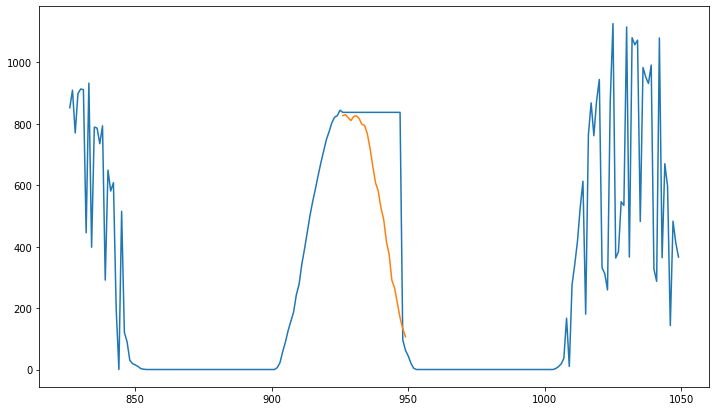

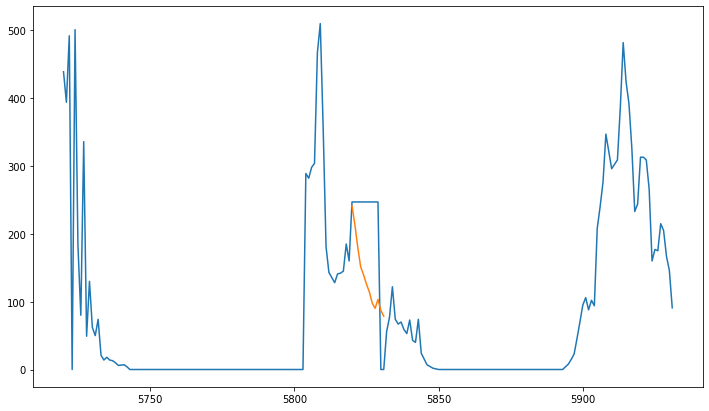

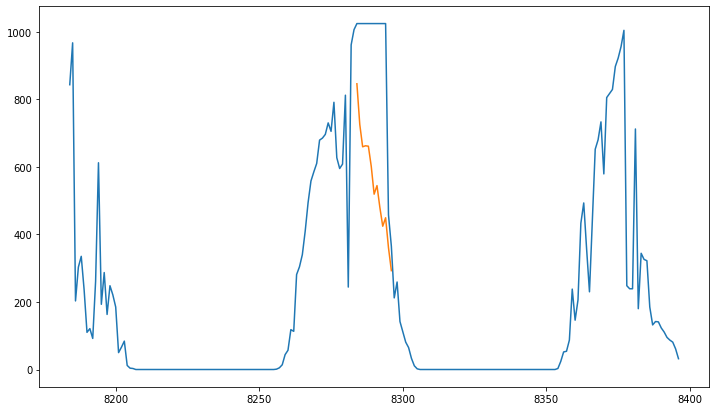

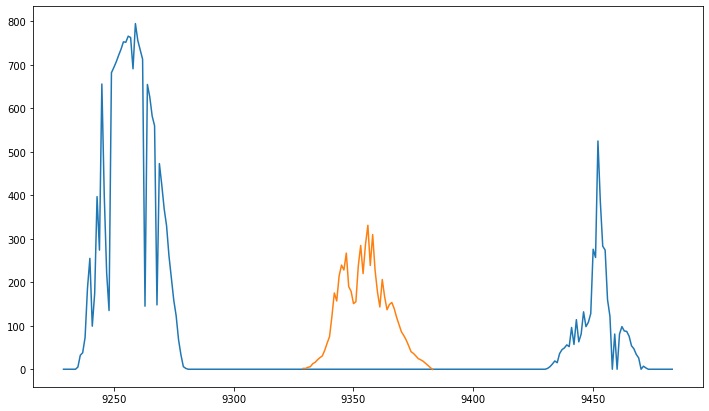

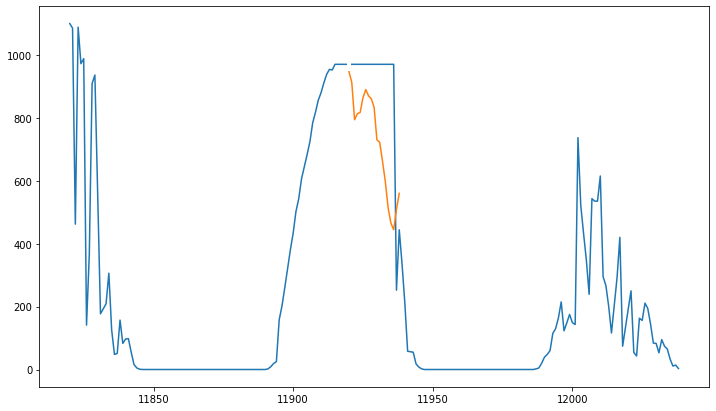

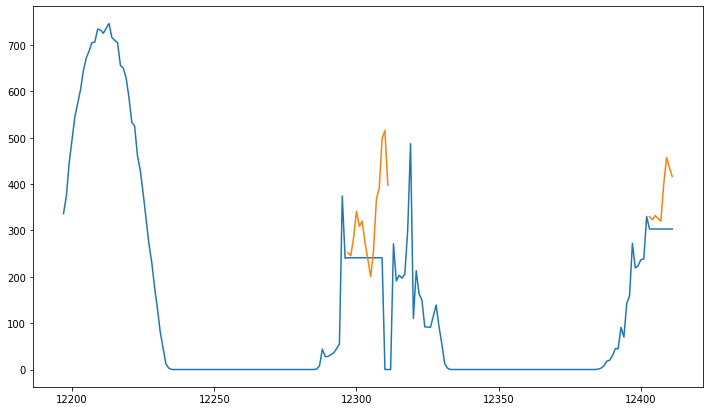

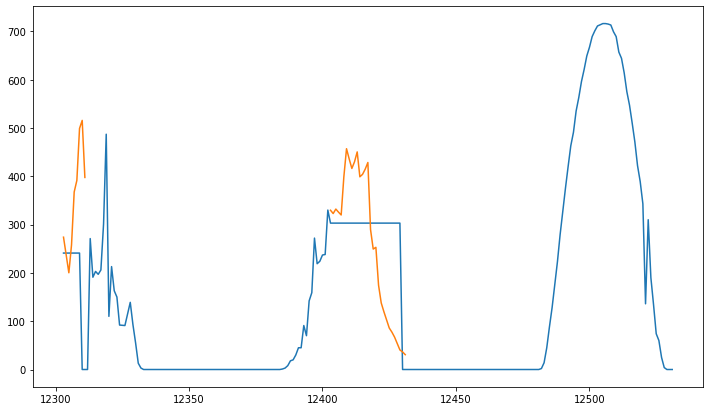

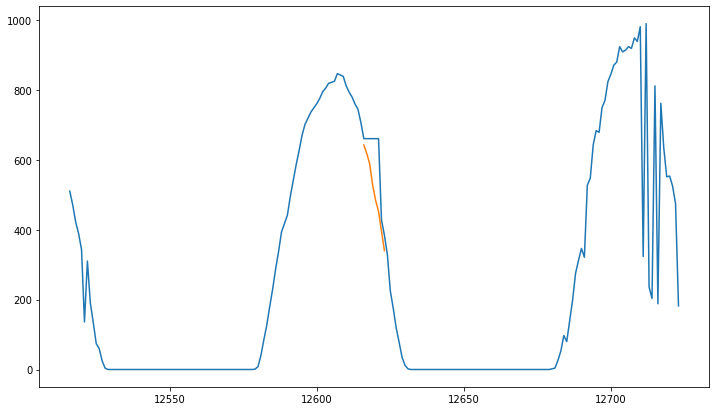

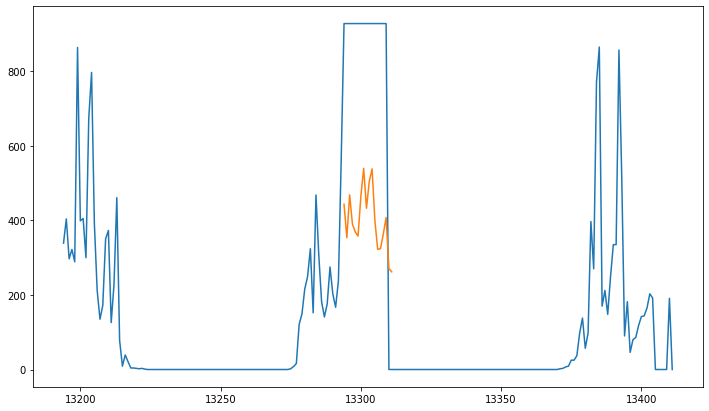

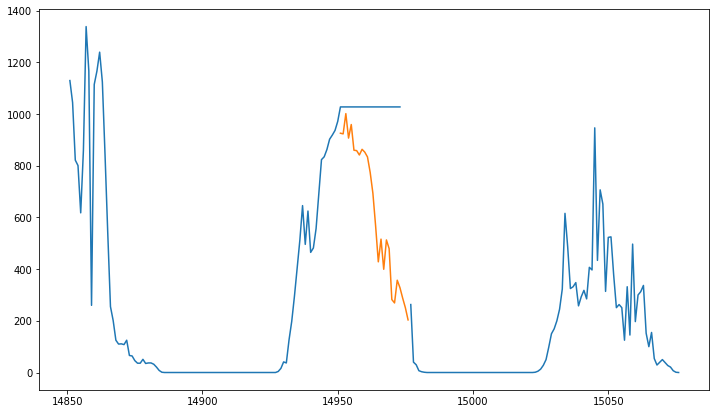

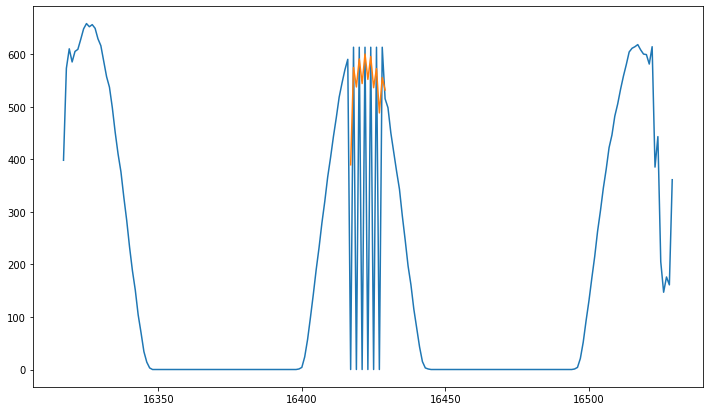

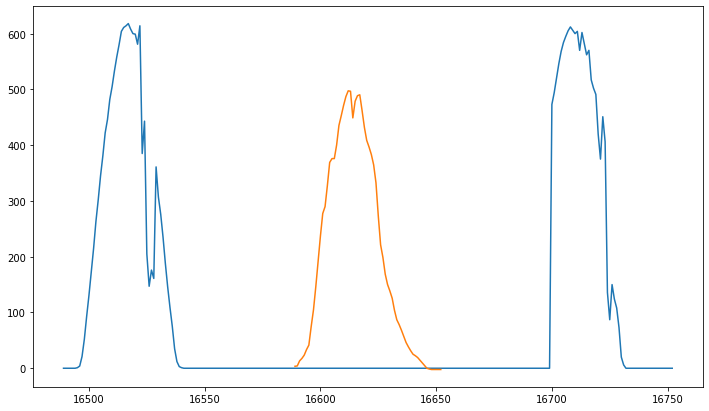

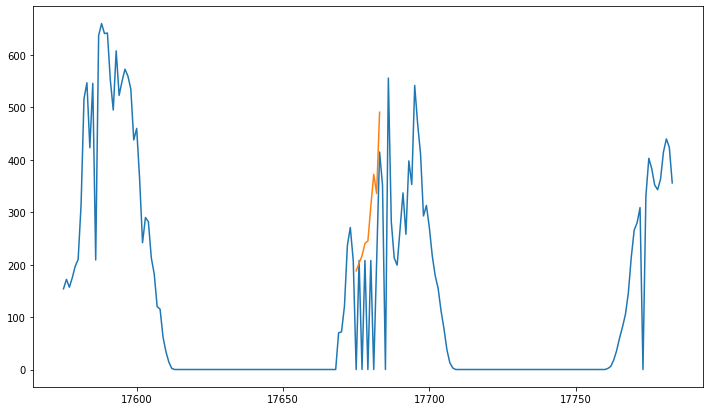

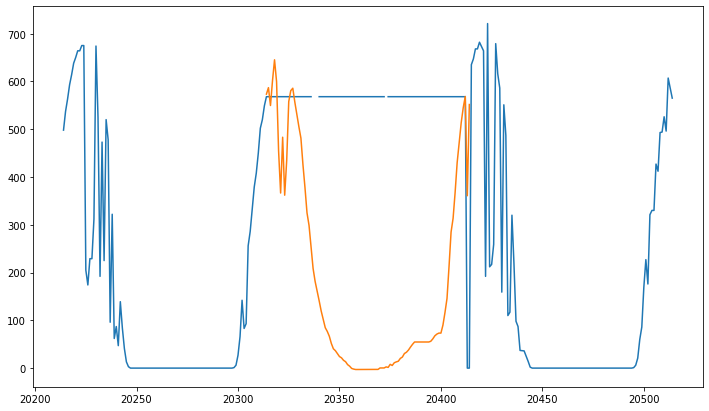

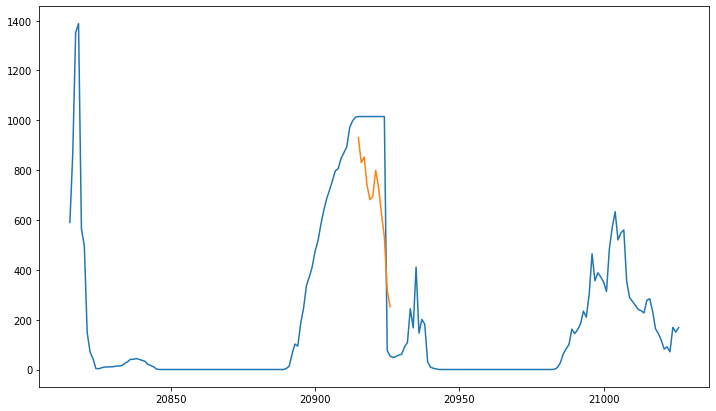

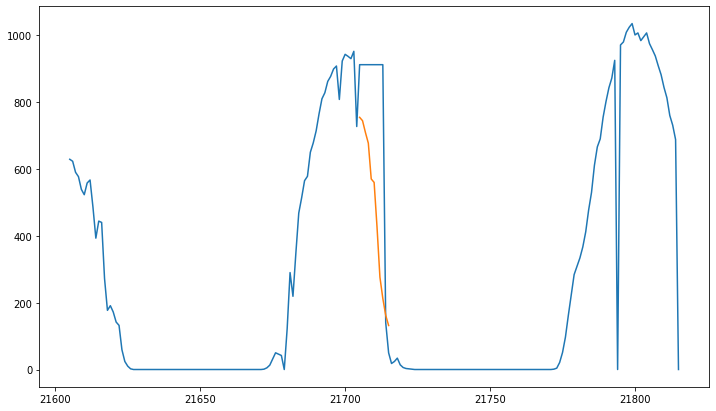

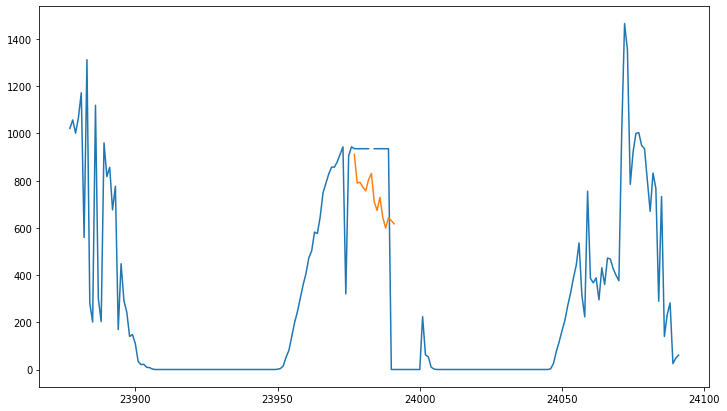

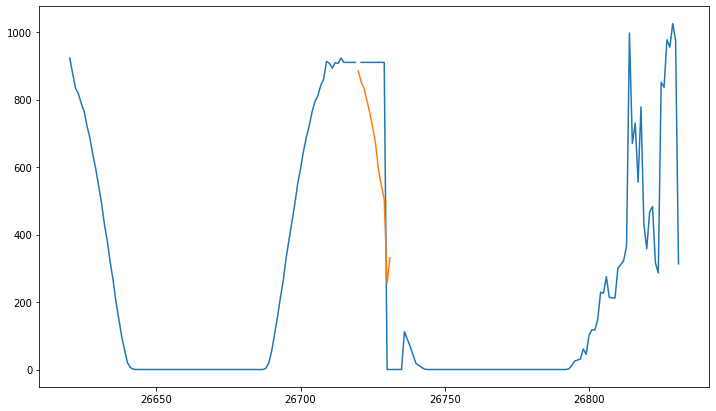

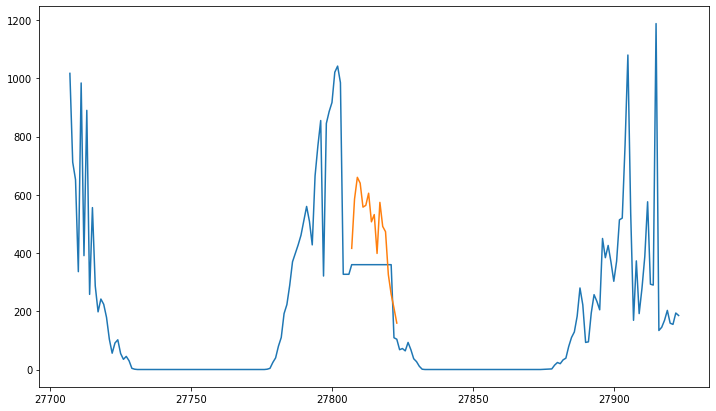

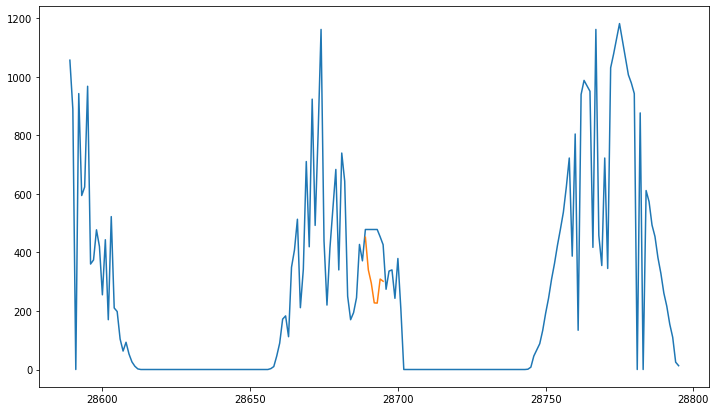

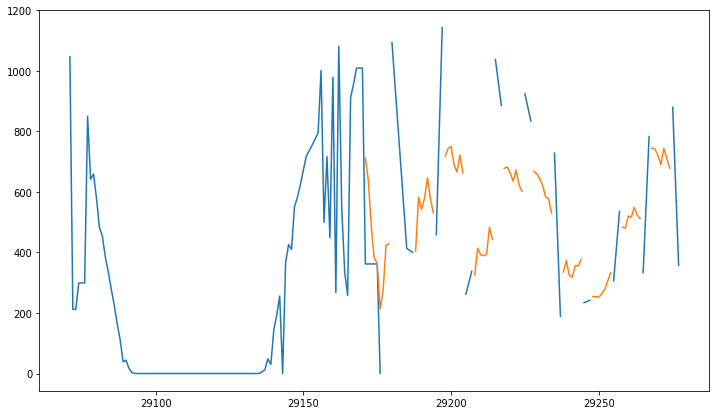

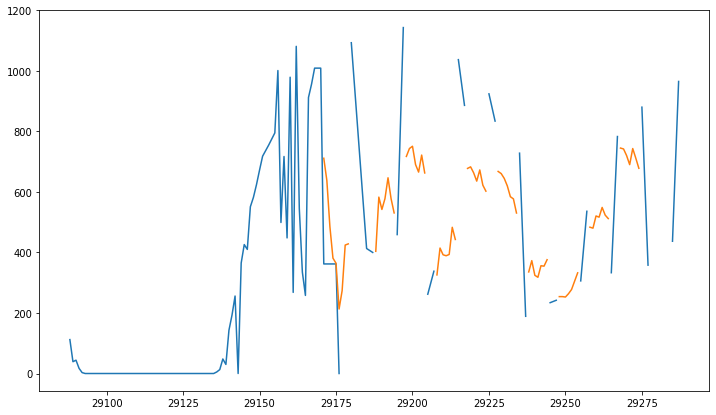

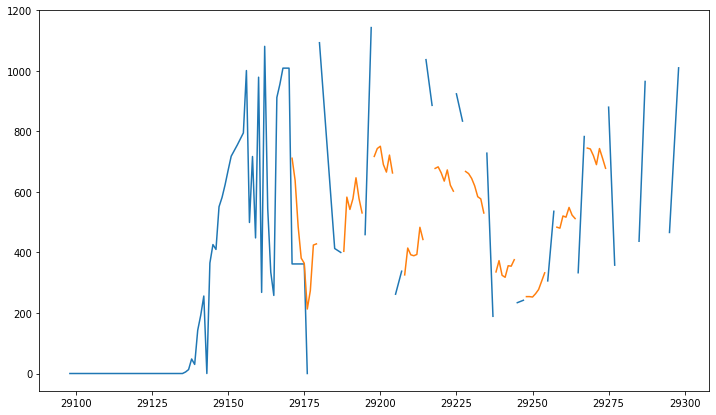

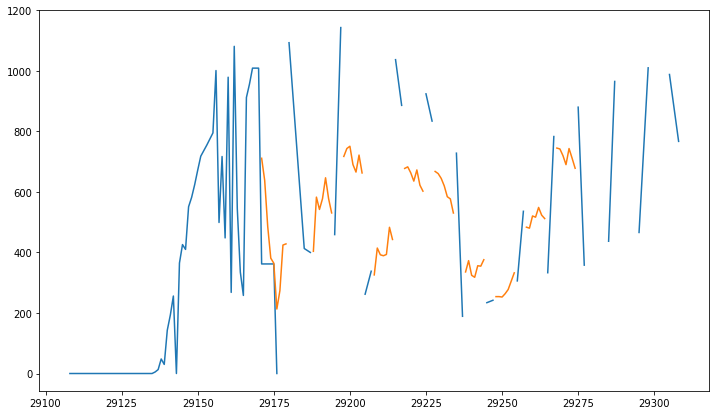

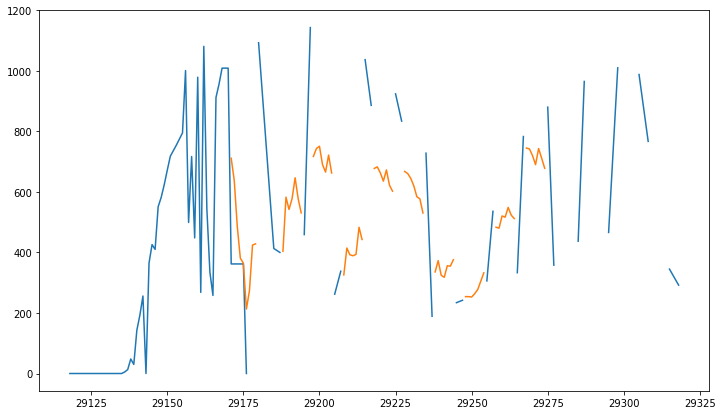

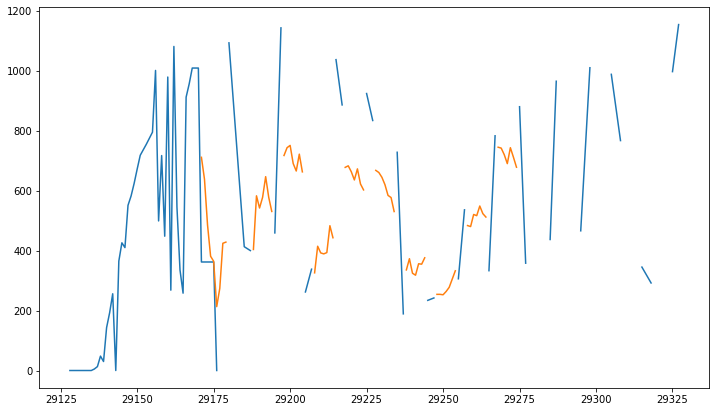

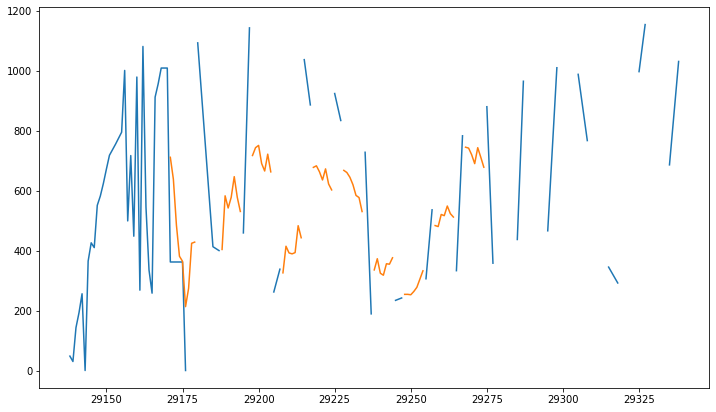

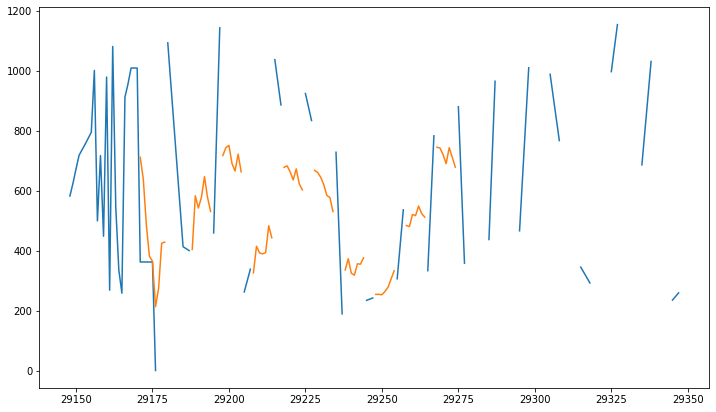

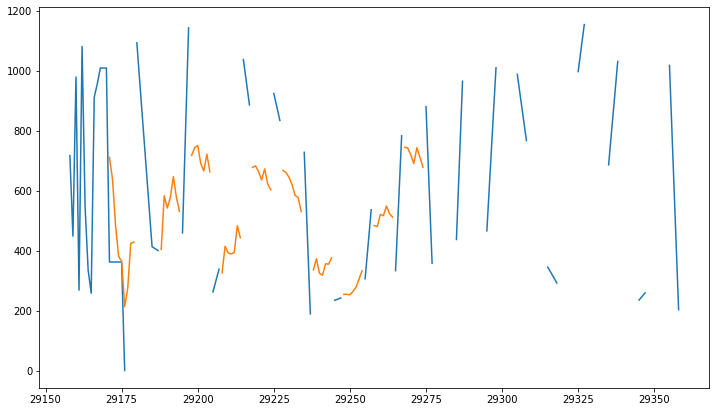

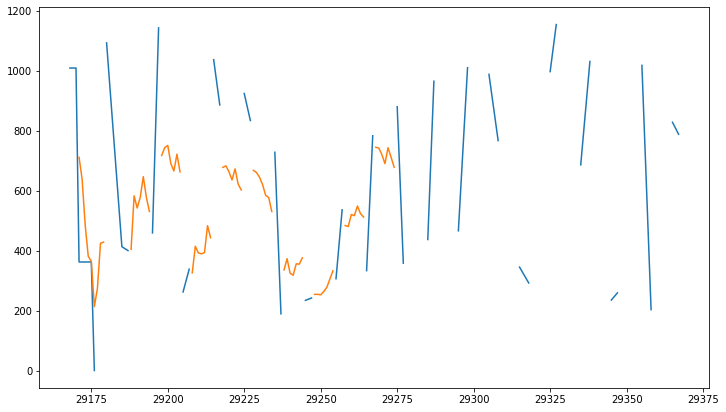

In [35]:
for r in range(30):
    start, stop = predict_regions[r][0] - 100, predict_regions[r][1] + 100
    plt.figure(figsize=(12,7))
    plt.plot(prediction['RadiacaoSolar_0'][start:stop] )
    plt.plot(prediction['RadiacaoSolar_0_pred'][start:stop]
             .where(prediction['RadiacaoSolar_0_error'][start:stop]))
    plt.show()